# Speech Attribution/Identification

This notebook takes a dataset containing campain speeches from Donald Trump and Hilary Clinton, and fine-tunes a Deberta model to predict which candidate the speech belongs to based on the final sentences of the speech.

This notebook was largely experimental. As I tried to improve the predictive performance of the model, I progressively formatted the input data.
<br/>
The data cleaning and formatting isn't optimised in this notebook, as I wanted to show the steps that I went through to get the best model performance.
<br/>
As in most ML experiments, formatting and cleaning the input data has a huge impact on model performance.

The dataset used in this notebook can be found here: https://www.kaggle.com/datasets/browndw/clintontrump-corpus


### Load/Import Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastai.imports import *
import re 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/clintontrump-corpus/clinton_trump.csv


Set path and load data:

In [2]:
path = Path('../input/clintontrump-corpus')
df = pd.read_csv(path/'clinton_trump.csv')

### Data Formatting and Cleaning

Shuffle the dataset:

In [3]:
df = df.sample(frac=1).reset_index(drop=True)
df = df.sample(frac=1).reset_index(drop=True)

Define a function that can identify the candidate based on the doc_id column:

In [4]:
 def extract_name(text): 
    if text.find('Trump') >= 0: return 1
    return 0

Label dataset:

In [5]:
df['label'] = df['doc_id'].map(extract_name).astype('float')

Check if dataset is balanced:


In [6]:
np.mean(df['label'])

0.7008547008547008

Remove redundant column

In [7]:
df = df.drop('doc_id', axis=1)

In [8]:
# Convert to lowercase
df['text'] = df['text'].map(str.lower)

### Data Cleaning Steps
- When cleaning the data, I first decided to remove the metadata at the start of each speech by deleting the everything contained within the first set of braces ("<>").
- I then realised that many speeches start with an introduction from another speaker. I decided to remove everything that comes before the candidate's first statements.
- I finally realised that there are often interjections by other speakers during the speech. I investigated further and found that interjections are always contained within braces ("<>"), while the candidate's speech is not. I decided to remove everything that's contained within brackets or braces, thus making my intial drop_metadata and drop_intro functions redundant.


In [9]:
# This function is now redundant
def drop_metadata(text):
    first_close = text.find('>')
    second_close = text.find('>', first_close +1 )
    return text[second_close+1:]

In [10]:
# This function is now redundant
def drop_intro(text):
    first_trump = text.find('<trump')
    if (first_trump >= 0):
        return text[first_trump:]
    
    first_hilary = text.find('<hilary')
    if (first_hilary >= 0):
        return text[first_hilary:]
    return text

In [11]:
# Drop all text contained in braces (<>) or parentheses
def drop_alt_speakers(text):
    return re.sub("[\(\<].*?[\)\>]", "", text)

### Further Details
- The Kaggle GPU only has enough RAM to handle small parts of the speech. 
- I decided to focus on the last 1200 characters of each speech. Sometimes sentences get cut off mid-sentence and this had a negative effect on model performance.
- Removing incomplete sentences from the start of the formatted speech resolved this issue.
- We also need to remove anything that could directly tell the model who the speaker is, like candidate names etc. These are replaced with something more generic.

In [12]:
def drop_incomplete_first_sen(text):
    first_stop = text.find('.')
    if (first_stop >= 0):
        return text[first_stop+2:]

In [13]:
# df['text'] = df['text'].map(drop_metadata)
# df['text'] = df['text'].map(drop_intro)
df['text'] = df['text'].map(drop_alt_speakers)
df['text'] = df['text'].str[-1200:]
df['text'] = df['text'].map(drop_incomplete_first_sen)
# Remove any remaining symbols or interjections
df['text'] = df['text'].str.replace('<applause>', '')
df['text'] = df['text'].str.replace('<cheering and applause>', '')
df['text'] = df['text'].str.replace('<crosstalk>', '')
df['text'] = df['text'].str.replace('<', '')
df['text'] = df['text'].str.replace('>', '')
df['text'] = df['text'].str.replace('\\', '')
df['text'] = df['text'].str.replace(':', ' :')   
df['text'] = df['text'].str.replace(' --', ',') 
# Remove candidate names
df['text'] = df['text'].str.replace('hillary clinton', 'the candidate')
df['text'] = df['text'].str.replace('hillary', 'the candidate')
df['text'] = df['text'].str.replace('clinton', 'the candidate')
df['text'] = df['text'].str.replace('donald trump', 'the candidate')
df['text'] = df['text'].str.replace('donald', 'the candidate')
df['text'] = df['text'].str.replace('trump', 'the candidate')

In [14]:
df

,text,label
0,"they have, as matt olsen pointed out, said they hoped that allah delivers america to the candidate. they have said that they hope that he is the president because it would give even more motivation to every jihadi, someone who has insulted muslims; has insulted a gold star family of an incredibly heroic captain khan; someone who has said he doesn't want to let muslims around the world even come to our country. that is a gift for isis, and that is what matt olsen, who knows more about this than the republicans trying to somehow muddy the waters, very clearly stated. that's what i mean. and ...",0.0
1,"we're going to take care of that. we're going to take care of that situation so quickly and you're going to be so happy and you're going to know you're going to have your company here for a long time, believe me. in this new future we are going to raise your wages. you're going to have competition. people are going to be looking for employees. they're going to be looking. companies, companies are going to be looking for people to work in that company. right now you can't get a job. and all our good jobs are gone. household incomes are over $4,000 less today than they were 16 years ago. th...",1.0
2,"we need to use technology more. we need to get information out. we need to have, you know, people be able to access easily information about government programs, or costs, or whatever it is that's on their minds. so, you know, that's what i'm going to be doing, i'm going to be talking about how we make college tuition free for under $125,000 per family and debt-free for everybody else. i think that, i think that's what people care about. oh! let me think! look, i like a lot of the world leaders. one of my favorites is angela merkel, because i think she's been an extraordinary strong lead...",0.0
3,"she was 92 years old. we're all equal and we all come from the same creator. if we remember that simple fact, then our future is truly limitless. there is nothing we as americans can't do. there's a biblical verse that i've often read and i want to repeat it again because i think it is so important to what we're trying to achieve right now for our country. it's from first john chapter four. ""no one has ever seen god, but if we love one another, god lives in us and his love is made complete in us."" so true. so true. imagine what our country could accomplish if we started working together ...",1.0
4,"bill o'reilly and others have said this is the single greatest phenomena they've ever seen. we have a movement like no other. we're going to make that movement incredible. and what we're going to end up with is this : a country that's not divided, a country that loves itself and loves its people. we're going to make a country where people are proud to come in, people are proud to come through the borders, people want to come through because they respect us and they respect our values. we are going to make a country that's wealthy again. we're going to make a country that's safe again. we'...",1.0
...,...,...
112,"it's a long time. seems like a long time ago. but we're six days away from the change you've been waiting for your entire life. it'll never happen again. it'll never, ever happen. it's not going to happen in four years. when i see cubans for the candidate, it'll never happen again. i'm telling you. this whole thing will never happen again. there's never been a movement like this in the history of our country, there's never been a movement like this. thank you. thank you. there has never been a movement like this in the history of our country, it's never happened. even the pundits, even t...",1.0
113,"we will put new american metal into the spine of this country, american metal and american steel. i will fight for every neglected part of the nation. and i will fight to bring us all together as one american people, which we're not. we are so badly divided. imagine what our country could accomplish, if we started working tog

In [15]:
df['text'][0]

"they have, as matt olsen pointed out, said they hoped that allah delivers america to the candidate. they have said that they hope that he is the president because it would give even more motivation to every jihadi, someone who has insulted muslims; has insulted a gold star family of an incredibly heroic captain khan; someone who has said he doesn't want to let muslims around the world even come to our country. that is a gift for isis, and that is what matt olsen, who knows more about this than the republicans trying to somehow muddy the waters, very clearly stated. that's what i mean. and look, i'm not asking for any special treatment. i, i know the road that i'm on. i've been on it for 25 years, and i just get up every day and keep moving forward. i love this country. i will serve it with my entire heart, mind and soul. i will do everything i can to protect america. and i will do everything i can to make sure the candidate is not president, for many reasons, but this latest informati

# Model Fine-Tuning

In [16]:
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader
import warnings,transformers,logging,torch
from transformers import TrainingArguments,Trainer
from transformers import AutoModelForSequenceClassification,AutoTokenizer

!pip install -q datasets
from datasets import Dataset


In [17]:
# disable/filter unnecesary warnings/logs
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [18]:
# create an evaluation dataset, which will NOT be used in model training
df, eval_df = train_test_split(df, test_size=0.2)
df = df.reset_index(drop=True)
eval_df = eval_df.reset_index(drop=True)

In [19]:
# Set up tokenization model and tokenisation function
model_nm = 'microsoft/deberta-v3-small'
tokz = AutoTokenizer.from_pretrained(model_nm)

def tok_func(x): return tokz(x["text"])

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

In [20]:
# Convert dataframe to Dataset, tokenize, and remove non-tokenised text
ds = Dataset.from_pandas(df)
tok_ds = ds.map(tok_func, batched=True)
tok_ds = tok_ds.remove_columns(['text'])

  0%|          | 0/1 [00:00<?, ?ba/s]

In [21]:
# Check result
tok_ds

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 93
})

In [22]:
# Create train/test split for model fine-tuning
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 69
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 24
    })
})

### IMPORTANT NOTE
When I started this problem, I planned to self-label the speeches and change the labels from binary to multi-class, with varying scores to represent the likely hood of the speech belonging to each candidate. 
<br/>
Due to this, I started with a correlation coefficient for the evaluation metric.
<br/>
I started labelling the data and realised that this approach wouldn't work, as my self-labelling was really poor.
<br/>
I switched to an accuracy metric instead, but found that as my dataset is very imbalaced, the model always predicted the dominant class.
<br/>
I changed back to the correlation metric, and found that the model performed much better.
<br/>
However, the model now no longer produces binary probabilities.
<br/>
One option would be to perform a logistic regression on the results, to determine a cut-off point which can be used to convert the output to binary results.
<br/>
This wasn't necessary though, as I was able to plot the predictions of the test set, and choose a cut-off point manually to apply to my evaluation dataset.

In [23]:
# Define evaluation function to calculate pearson correlation coefficient
def corr(eval_pred): 
    print('in eval')
    print(eval_pred)
    return {'pearson': np.corrcoef(*eval_pred)[0][1]}

In [24]:
lr,bs = 8e-5,128
wd,epochs = 0.01,4

In [25]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=wd, report_to='none')

In [26]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)#2, id2label=id2label, label2id=label2id)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
               tokenizer=tokz, compute_metrics=corr)

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

In [27]:
trainer.train();

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.496254,-0.439031
2,No log,0.496254,-0.439031
3,No log,0.333597,0.683235
4,No log,0.242922,0.800376


in eval
in eval
in eval
in eval


## Evaluation

We'll plot the predictions of the test set and choose a cut-off point:

In [28]:
test_preds = trainer.predict(dds['test']).predictions.astype(float)
test_preds

in eval


array([0.49804688, 0.4909668 , 0.50927734, 0.50244141, 0.50830078,
       0.50683594, 0.51269531, 0.48974609, 0.49804688, 0.50244141,
       0.50195312, 0.49291992, 0.50830078, 0.50878906, 0.51074219,
       0.50927734, 0.50634766, 0.51123047, 0.51318359, 0.50439453,
       0.4831543 , 0.51074219, 0.49707031, 0.50537109])

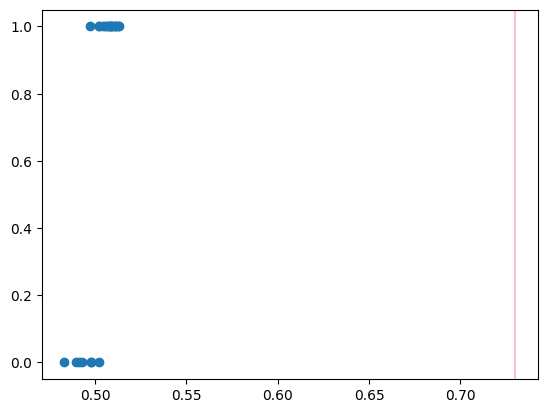

In [29]:
plt.scatter(test_preds,dds['test']['label'])
plt.axvline(x=0.73, color='pink')

Let's use the cutoff point of 0.73 and see how this performs for our evaluation datset.

In [30]:
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)
eval_labels = eval_ds['label']
eval_ds = eval_ds.remove_columns('label')

  0%|          | 0/1 [00:00<?, ?ba/s]

In [31]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds

array([[0.50927734],
       [0.51367188],
       [0.50830078],
       [0.47485352],
       [0.51220703],
       [0.5078125 ],
       [0.49926758],
       [0.51123047],
       [0.49682617],
       [0.50048828],
       [0.50927734],
       [0.50976562],
       [0.50097656],
       [0.49975586],
       [0.49902344],
       [0.5       ],
       [0.50292969],
       [0.48901367],
       [0.48901367],
       [0.50244141],
       [0.49975586],
       [0.4909668 ],
       [0.49365234],
       [0.51074219]])

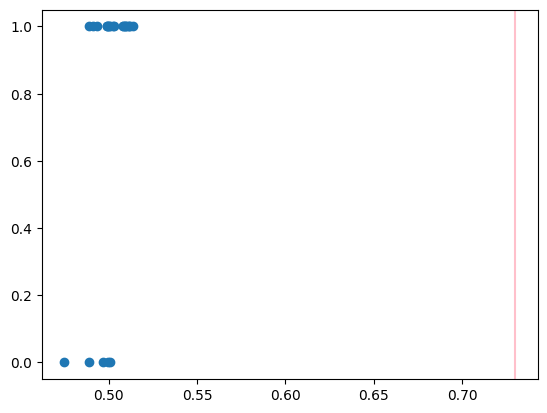

In [32]:
plt.scatter(preds,eval_labels)
plt.axvline(x=0.73, color='pink')

## Result
The cutoff point performs just as well for the evaluation dataset.
<br/>
We could use this cutoff point to covert the output values to binary values.
<br/>
The model has perfect performance in this case.